# Covid-19 v Praze

Data jsou zpožděna oproti celorepublikovým číslům o týden z důvodů validace.

In [8]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import urllib.request
import json
import datetime as dt

plt.style.use('ggplot')

def autolabel(rects, ax, val_prec=0):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        if height!=height:height=0
        if val_prec == 0:
            height_str = f'{height:.0f}'
        elif val_prec == 1:
            height_str = f'{height:.1f}'            
        else:
            height_str = f'{height:.2f}'
        ax.annotate(height_str,
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

with urllib.request.urlopen("https://onemocneni-aktualne.mzcr.cz/api/v2/covid-19/kraj-okres-nakazeni-vyleceni-umrti.json") as url:
    data = json.loads(url.read().decode())


    df = pd.DataFrame(data['data'])
    df['datum'] = pd.to_datetime(df['datum'], errors='coerce')
    df['datum'] = df['datum'].dt.date
    
    display(df.tail())

,datum,kraj_nuts_kod,okres_lau_kod,kumulativni_pocet_nakazenych,kumulativni_pocet_vylecenych,kumulativni_pocet_umrti
9158,2020-06-27,CZ080,CZ0802,394,262,9
9159,2020-06-27,CZ080,CZ0803,994,141,5
9160,2020-06-27,CZ080,CZ0804,107,88,5
9161,2020-06-27,CZ080,CZ0805,208,190,8
9162,2020-06-27,CZ080,CZ0806,544,418,36


In [9]:
# filter only Prague data
df = df.loc[df['kraj_nuts_kod']=='CZ010']
df = df.drop(['kraj_nuts_kod'], axis=1).drop(['okres_lau_kod'], axis=1)
df.reset_index(drop=True, inplace=True)

# add daily counts + other params
df.rename(columns={'datum': 'date', 
                   'kumulativni_pocet_nakazenych': 'positive_total',
                  'kumulativni_pocet_vylecenych': 'recovered_total', 
                  'kumulativni_pocet_umrti': 'deceased_total'}, inplace=True)

df['positive_daily'] = df['positive_total'] - df['positive_total'].shift(1)
df['recovered_daily'] = df['recovered_total'] - df['recovered_total'].shift(1)
df['deceased_daily'] = df['deceased_total'] - df['deceased_total'].shift(1)

df['active'] = df['positive_total'] - df['recovered_total'] - df['deceased_total'] 

df['positive_increase']=0
df['positive_increase'] = (df['positive_total'] - \
                  df['positive_total'].shift(1)) / \
                  df['positive_total'].shift(1)
df['positive_increase_5d'] = (df['positive_increase'] + \
                              df['positive_increase'].shift(1) + \
                              df['positive_increase'].shift(2) + \
                              df['positive_increase'].shift(3) + \
                              df['positive_increase'].shift(4)) / 5

df['growth_factor'] = df['positive_daily'] / df['positive_daily'].shift(1)
df['ones'] = 1

df.tail()

,date,positive_total,recovered_total,deceased_total,positive_daily,recovered_daily,deceased_daily,active,positive_increase,positive_increase_5d,growth_factor,ones
114,2020-06-23,2321,1512,100,16.0,1.0,0.0,709,0.006941,0.005254,2.285714,1
115,2020-06-24,2341,1518,103,20.0,6.0,3.0,720,0.008617,0.005562,1.250000,1
116,2020-06-25,2359,1523,103,18.0,5.0,0.0,733,0.007689,0.005782,0.900000,1
117,2020-06-26,2362,1535,103,3.0,12.0,0.0,724,0.001272,0.005513,0.166667,1
118,2020-06-27,2375,1537,103,13.0,2.0,0.0,735,0.005504,0.006005,4.333333,1


## Vývoj počtu pozitivně testovaných

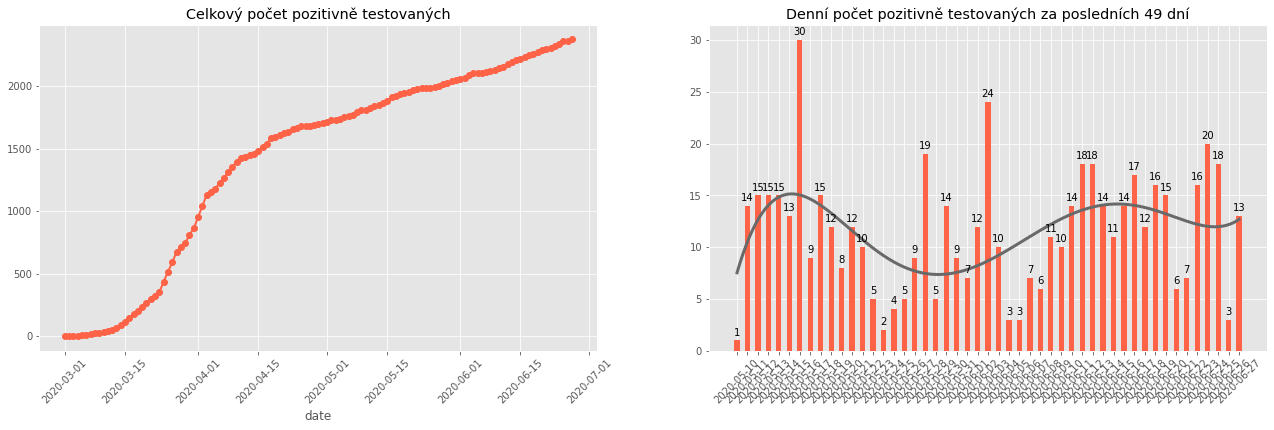

In [10]:
fig = plt.figure(figsize=(22,6))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

df.plot(x='date', 
                        y='positive_total', 
                        kind='line', 
                        style='tomato',
                        marker='o',
                        linewidth=2,                   
                        legend=False,
                        grid=True, 
                        ax=ax1,
                        title='Celkový počet pozitivně testovaných')
ax1.tick_params(axis="x", rotation=45) 

days_back = 49

x = np.arange(days_back)
x_labels = np.array(df.iloc[-days_back:, df.columns.get_loc('date')])
y = np.array(df.iloc[-days_back:, df.columns.get_loc('positive_daily')])

z = np.polyfit(x,y,5)
p = np.poly1d(z)
xnew = np.linspace(x[0], x[-1], 1000)

rects1 = ax2.bar(x, y, width=.5, color='tomato')
ax2.set_xticks(np.arange(len(x)))
ax2.set_xticklabels(x_labels, rotation=45)
autolabel(rects1, ax2)

ax2.plot(xnew, p(xnew), 'dimgray', linewidth=3)

ax2.grid(True)
ax2.set_title(f'Denní počet pozitivně testovaných za posledních {days_back} dní')

plt.show()

## Vývoj průměrného denního nárůstu pozitivně testovaných 

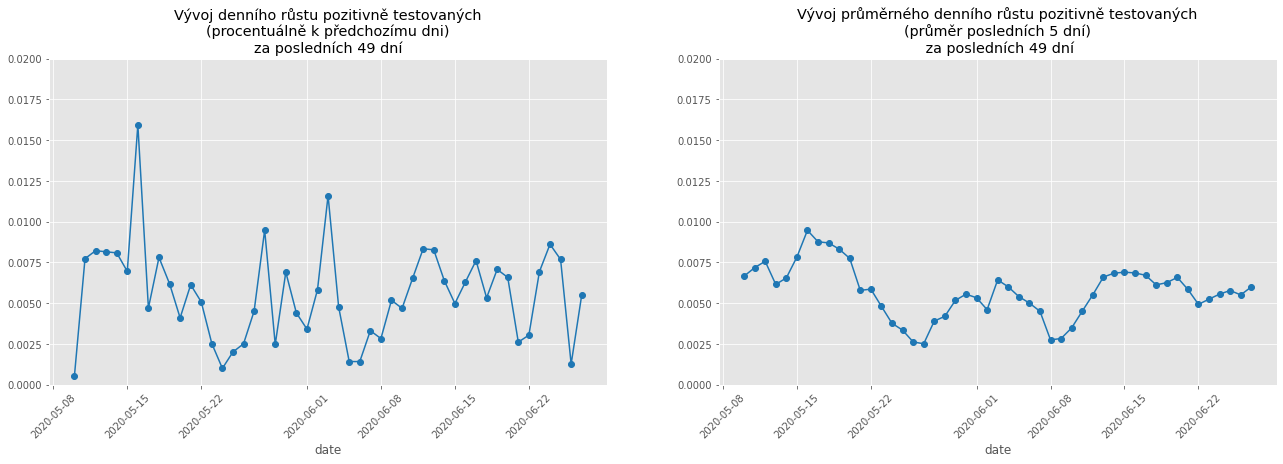

In [11]:

days_back = 49

fig = plt.figure(figsize=(22,6))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)


df.iloc[-days_back:].plot(x='date',
             y='positive_increase', 
             kind='line', 
             grid=True, 
             legend=False,
             ylim=(0,0.02),
             style='tab:blue',
             marker='o',
             ax=ax1,
             title=f'Vývoj denního růstu pozitivně testovaných\n(procentuálně k předchozímu dni)\nza posledních {days_back} dní')
ax1.tick_params(axis="x", rotation=45) 

df.iloc[-days_back:].plot(x='date',
             y='positive_increase_5d', 
             kind='line', 
             grid=True, 
             legend=False,
             ylim=(0,0.02),
             style='tab:blue',
             marker='o',
             ax=ax2,
             title=f'Vývoj průměrného denního růstu pozitivně testovaných\n(průměr posledních 5 dní)\n za posledních {days_back} dní')
ax2.tick_params(axis="x", rotation=45) 


plt.show()


# Počty uzdravených a zemřelých

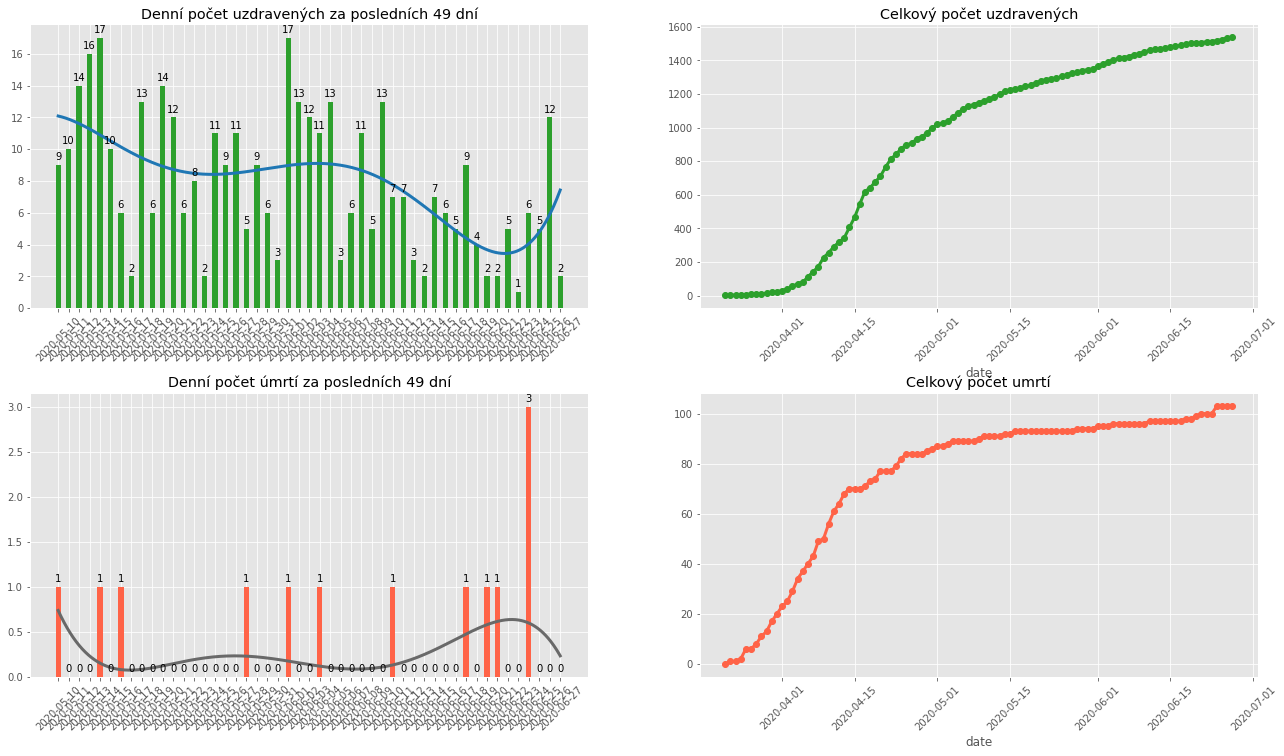

In [12]:
days_back=49

#print(f'Poslední den {df.iloc[-1, 0]} (neúplná data): {df.iloc[-1,6]} uzdravených, {df.iloc[-1,7]} zemřelých')
fig = plt.figure(figsize=(22,12))
ax1 = fig.add_subplot(221)
ax2 = fig.add_subplot(222)
ax3 = fig.add_subplot(223)
ax4 = fig.add_subplot(224)

x = np.arange(days_back)
x_labels = np.array(df.iloc[-days_back:, df.columns.get_loc('date')])
y = np.array(df.iloc[-days_back:, df.columns.get_loc('recovered_daily')]) ## 'recovered' -28: = poslední 4 týdny, 0 = beru jen pole s indexem 0 (value)

z = np.polyfit(x,y,5)
p = np.poly1d(z)
xnew = np.linspace(x[0], x[-1], 1000)

rects1 = ax1.bar(x, y, width=.5, color='tab:green')
ax1.set_xticks(np.arange(len(x)))
ax1.set_xticklabels(x_labels, rotation=45)
autolabel(rects1, ax1)

ax1.plot(xnew, p(xnew), 'tab:blue', linewidth=3)
ax1.set_title(f'Denní počet uzdravených za posledních {days_back} dní')
plt.subplots_adjust(hspace=0.3)

df[df['date']>dt.date(2020, 3, 20)].plot(x='date', 
            y='recovered_total', 
            kind='line',
            linewidth=3,
            style='tab:green',
            marker='o',
            grid=True, 
            legend=False,
            ax=ax2,
            title='Celkový počet uzdravených')
ax2.tick_params(axis="x", rotation=45)

x = np.arange(days_back)
x_labels = np.array(df.iloc[-days_back:, df.columns.get_loc('date')])
y = np.array(df.iloc[-days_back:, df.columns.get_loc('deceased_daily')])

z = np.polyfit(x,y,5)
p = np.poly1d(z)
xnew = np.linspace(x[0], x[-1], 1000)

rects2 = ax3.bar(x, y, width=.5, color='tomato')
ax3.set_xticks(np.arange(len(x)))
ax3.set_xticklabels(x_labels, rotation=45)
autolabel(rects2, ax3)

ax3.plot(xnew, p(xnew), 'dimgray', linewidth=3)
ax3.set_title(f'Denní počet úmrtí za posledních {days_back} dní')
#plt.subplots_adjust(hspace=0.3)

df[df['date']>dt.date(2020, 3, 20)].plot(x='date', 
            y='deceased_total', 
            kind='line',
            linewidth=3,
            style='tomato',
            marker='o',
            grid=True,
            legend=False,
            ax=ax4,
            title='Celkový počet umrtí')
ax4.tick_params(axis="x", rotation=45)

plt.show()

# Celkový počet pozitivně testovaných vs. aktivní případy

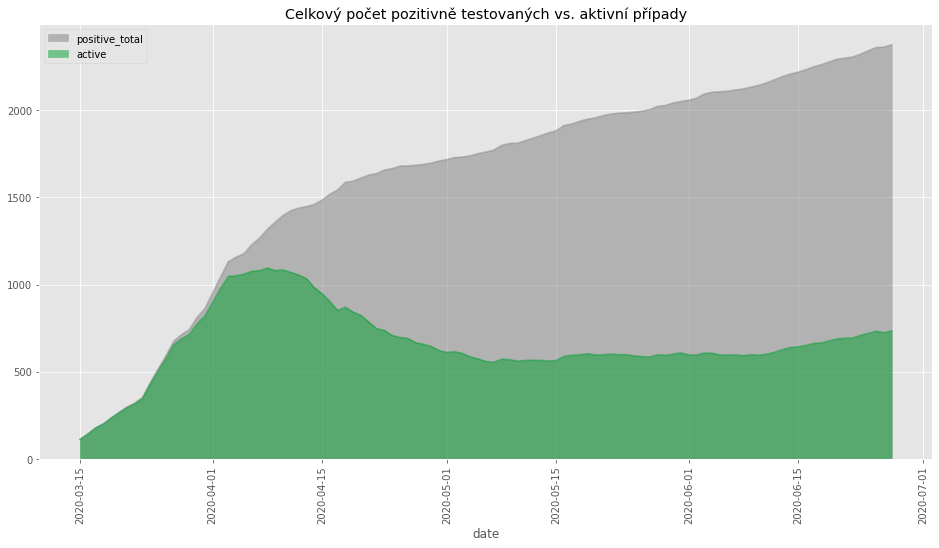

In [13]:
df[df['positive_total']>100].plot(x='date', 
            y=['positive_total', 'active'], 
            kind='area', 
            stacked=False, 
            color=['.5','#00A030'],
            figsize=(16, 8),
            grid=True, 
            title='Celkový počet pozitivně testovaných vs. aktivní případy')
plt.xticks(rotation=90)
plt.show()

In [14]:
# save data for later use
df.to_csv('data-praha-' + df.iloc[-1, 0].strftime('%Y-%m-%d') + '.csv', index=False)